Загрузка данных BTCUSDT с 01.05.2025 по 17.05.2025...
Загружено 1000 свечей.
Расчет индикатора ZigZag...
Определение уровней поддержки и сопротивления...
Найдено 2 уровней поддержки и 1 уровней сопротивления.
Построение графика...


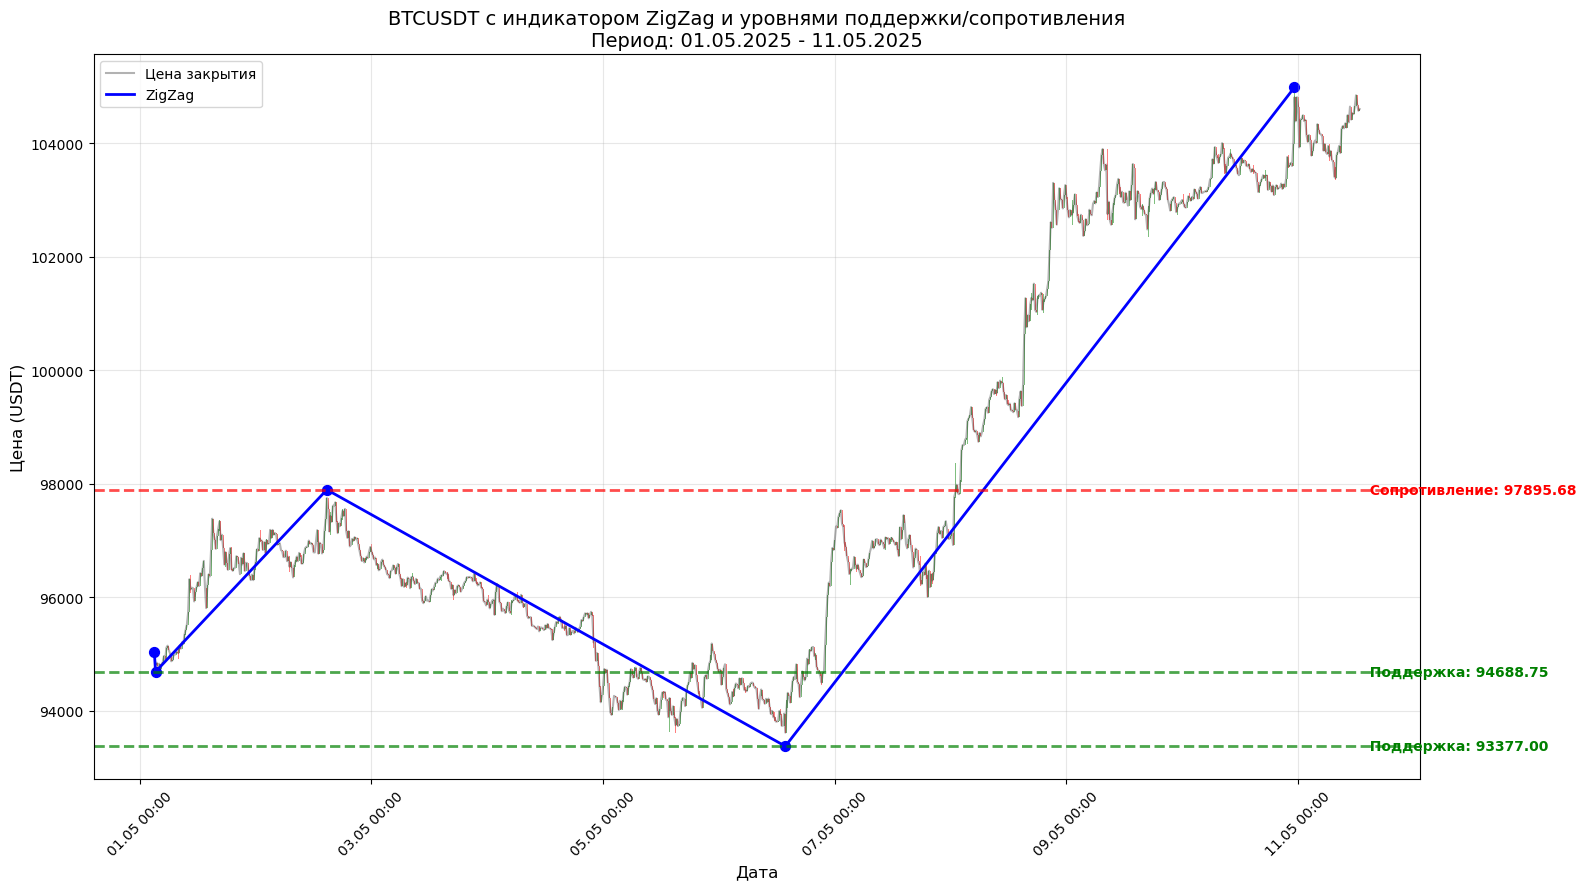

Анализ завершен. График сохранен в файл 'btcusdt_zigzag_support_resistance.png'.


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from datetime import datetime, timedelta
import matplotlib.dates as mdates

# Функция для получения данных BTCUSDT с Binance API
def get_binance_data(symbol, interval, start_date, end_date):
    base_url = "https://api.binance.com/api/v3/klines"
    
    # Преобразование дат в миллисекунды (timestamp)
    start_ms = int(datetime.strptime(start_date, "%d.%m.%Y").timestamp() * 1000)
    end_ms = int(datetime.strptime(end_date, "%d.%m.%Y").timestamp() * 1000)
    
    # Параметры запроса
    params = {
        "symbol": symbol,
        "interval": interval,
        "startTime": start_ms,
        "endTime": end_ms,
        "limit": 1000  # Максимальное количество свечей
    }
    
    response = requests.get(base_url, params=params)
    data = response.json()
    
    # Создание DataFrame
    df = pd.DataFrame(data, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume', 
                                    'close_time', 'quote_asset_volume', 'number_of_trades',
                                    'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'])
    
    # Преобразование типов данных
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df['open'] = df['open'].astype(float)
    df['high'] = df['high'].astype(float)
    df['low'] = df['low'].astype(float)
    df['close'] = df['close'].astype(float)
    df['volume'] = df['volume'].astype(float)
    
    return df

# Функция для расчета индикатора ZigZag
def calculate_zigzag(df, deviation=5):
    """
    Рассчитывает индикатор ZigZag на основе ценовых данных.
    
    Параметры:
    df: DataFrame с данными цен
    deviation: процентное отклонение для определения точек разворота
    
    Возвращает: список точек ZigZag (индекс, цена)
    """
    high = df['high'].values
    low = df['low'].values
    price_range = max(df['high'].max() - df['low'].min(), 1e-10)
    dev_threshold = price_range * deviation / 100
    
    zigzag_points = []
    current_dir = 0  # 0: неопределенно, 1: восходящий тренд, -1: нисходящий тренд
    last_high_idx = 0
    last_low_idx = 0
    last_high = high[0]
    last_low = low[0]
    
    for i in range(1, len(df)):
        # Проверка на новый максимум
        if high[i] > last_high:
            last_high = high[i]
            last_high_idx = i
            
            # Если мы находимся в нисходящем тренде и отклонение достаточно большое
            if current_dir == -1 and last_high - last_low >= dev_threshold:
                zigzag_points.append((last_low_idx, last_low))
                current_dir = 1
                
        # Проверка на новый минимум
        if low[i] < last_low:
            last_low = low[i]
            last_low_idx = i
            
            # Если мы находимся в восходящем тренде и отклонение достаточно большое
            if current_dir == 1 and last_high - last_low >= dev_threshold:
                zigzag_points.append((last_high_idx, last_high))
                current_dir = -1
                
        # Инициализация направления, если оно еще не определено
        if current_dir == 0 and i > 10:
            if last_high - low[0] > high[0] - last_low:
                current_dir = -1
                zigzag_points.append((0, high[0]))
            else:
                current_dir = 1
                zigzag_points.append((0, low[0]))
    
    # Добавление последней точки
    if current_dir == 1:
        zigzag_points.append((last_high_idx, last_high))
    else:
        zigzag_points.append((last_low_idx, last_low))
    
    return zigzag_points

# Функция для определения уровней поддержки и сопротивления
def find_support_resistance(df, zigzag_points, price_threshold=0.5, time_threshold=10):
    """
    Находит уровни поддержки и сопротивления на основе точек ZigZag.
    
    Параметры:
    df: DataFrame с данными цен
    zigzag_points: список точек ZigZag
    price_threshold: пороговое значение для группировки близких цен (в процентах)
    time_threshold: минимальное количество свечей между уровнями
    
    Возвращает: кортеж (уровни поддержки, уровни сопротивления)
    """
    # Извлечение цен из точек ZigZag
    prices = [point[1] for point in zigzag_points]
    indices = [point[0] for point in zigzag_points]
    
    # Определение максимальной и минимальной цены для процентного порога
    price_range = max(prices) - min(prices)
    threshold = price_range * price_threshold / 100
    
    # Списки для уровней поддержки и сопротивления
    support_levels = []
    resistance_levels = []
    
    # Классификация точек как впадины (поддержка) или пики (сопротивление)
    for i in range(1, len(prices) - 1):
        idx = indices[i]
        price = prices[i]
        
        # Если точка - минимум (поддержка)
        if price < prices[i - 1] and price < prices[i + 1]:
            # Проверка, близка ли цена к существующим уровням поддержки
            is_new_level = True
            for level in support_levels:
                if abs(price - level) < threshold:
                    is_new_level = False
                    break
            
            if is_new_level:
                support_levels.append(price)
        
        # Если точка - максимум (сопротивление)
        elif price > prices[i - 1] and price > prices[i + 1]:
            # Проверка, близка ли цена к существующим уровням сопротивления
            is_new_level = True
            for level in resistance_levels:
                if abs(price - level) < threshold:
                    is_new_level = False
                    break
            
            if is_new_level:
                resistance_levels.append(price)
    
    return support_levels, resistance_levels

# Функция для построения графика
def plot_chart_with_levels(df, zigzag_points, support_levels, resistance_levels):
    """
    Строит график цены с индикатором ZigZag и уровнями поддержки/сопротивления.
    
    Параметры:
    df: DataFrame с данными цен
    zigzag_points: список точек ZigZag
    support_levels: список уровней поддержки
    resistance_levels: список уровней сопротивления
    """
    fig, ax = plt.figure(figsize=(16, 9)), plt.subplot(111)
    
    # Построение графика цены
    ax.plot(df['timestamp'], df['close'], color='black', alpha=0.3, label='Цена закрытия')
    
    # Построение свечного графика
    width = 0.8 * (df['timestamp'].iloc[1] - df['timestamp'].iloc[0]).total_seconds() / 86400
    up = df[df['close'] >= df['open']]
    down = df[df['close'] < df['open']]
    
    # Зеленые свечи (цена растет)
    ax.bar(up['timestamp'], up['close'] - up['open'], width, bottom=up['open'], color='green', alpha=0.5)
    ax.bar(up['timestamp'], up['high'] - up['close'], width*0.1, bottom=up['close'], color='green', alpha=0.5)
    ax.bar(up['timestamp'], up['low'] - up['open'], width*0.1, bottom=up['open'], color='green', alpha=0.5)
    
    # Красные свечи (цена падает)
    ax.bar(down['timestamp'], down['close'] - down['open'], width, bottom=down['open'], color='red', alpha=0.5)
    ax.bar(down['timestamp'], down['high'] - down['open'], width*0.1, bottom=down['open'], color='red', alpha=0.5)
    ax.bar(down['timestamp'], down['low'] - down['close'], width*0.1, bottom=down['close'], color='red', alpha=0.5)
    
    # Построение линий ZigZag
    zigzag_indices = [point[0] for point in zigzag_points]
    zigzag_prices = [point[1] for point in zigzag_points]
    zigzag_timestamps = [df['timestamp'].iloc[idx] for idx in zigzag_indices]
    
    ax.plot(zigzag_timestamps, zigzag_prices, color='blue', linewidth=2, label='ZigZag')
    ax.scatter(zigzag_timestamps, zigzag_prices, color='blue', s=50)
    
    # Построение уровней поддержки
    for level in support_levels:
        ax.axhline(y=level, color='green', linestyle='--', alpha=0.7, linewidth=2)
        ax.text(df['timestamp'].iloc[-1], level, f'  Поддержка: {level:.2f}', 
                verticalalignment='center', color='green', fontweight='bold')
    
    # Построение уровней сопротивления
    for level in resistance_levels:
        ax.axhline(y=level, color='red', linestyle='--', alpha=0.7, linewidth=2)
        ax.text(df['timestamp'].iloc[-1], level, f'  Сопротивление: {level:.2f}', 
                verticalalignment='center', color='red', fontweight='bold')
    
    # Настройка графика
    plt.title(f'BTCUSDT с индикатором ZigZag и уровнями поддержки/сопротивления\n'
              f'Период: {df["timestamp"].iloc[0].strftime("%d.%m.%Y")} - {df["timestamp"].iloc[-1].strftime("%d.%m.%Y")}',
              fontsize=14)
    plt.xlabel('Дата', fontsize=12)
    plt.ylabel('Цена (USDT)', fontsize=12)
    plt.grid(alpha=0.3)
    plt.legend()
    
    # Форматирование оси X для лучшего отображения дат
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m %H:%M'))
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.savefig('btcusdt_zigzag_support_resistance.png', dpi=300)
    plt.show()

# Основной код
def main():
    # Параметры
    symbol = "BTCUSDT"
    interval = "15m"
    start_date = "01.05.2025"
    end_date = "17.05.2025"
    
    # Получение данных
    print(f"Загрузка данных {symbol} с {start_date} по {end_date}...")
    df = get_binance_data(symbol, interval, start_date, end_date)
    print(f"Загружено {len(df)} свечей.")
    
    # Расчет индикатора ZigZag
    print("Расчет индикатора ZigZag...")
    zigzag_points = calculate_zigzag(df, deviation=3)  # 3% отклонение
    
    # Определение уровней поддержки и сопротивления
    print("Определение уровней поддержки и сопротивления...")
    support_levels, resistance_levels = find_support_resistance(df, zigzag_points, 
                                                            price_threshold=0.3, 
                                                            time_threshold=12)
    
    print(f"Найдено {len(support_levels)} уровней поддержки и {len(resistance_levels)} уровней сопротивления.")
    
    # Построение графика
    print("Построение графика...")
    plot_chart_with_levels(df, zigzag_points, support_levels, resistance_levels)
    
    print("Анализ завершен. График сохранен в файл 'btcusdt_zigzag_support_resistance.png'.")

if __name__ == "__main__":
    main()

### В данном коде уровни поддержки и сопротивления выстраиваются на основе точек ZigZag-индикатора. 

## Процесс происходит в несколько этапов:
#### 1. Расчет индикатора ZigZag
* Сначала код рассчитывает точки индикатора ZigZag с помощью функции calculate_zigzag():
* ZigZag определяет значимые развороты цены, отфильтровывая мелкие колебания
* Параметр deviation (3% в этом коде) определяет минимальное процентное изменение цены для регистрации точки разворота
* Алгоритм отслеживает последовательные максимумы и минимумы, добавляя их в список zigzag_points только при достаточном ценовом отклонении

#### 2. Идентификация уровней в функции find_support_resistance()
После получения точек ZigZag код выделяет уровни поддержки и сопротивления:
* pythondef find_support_resistance(df, zigzag_points, price_threshold=0.5, time_threshold=10):

Расчет ценового порога для группировки похожих уровней:
* pythonprice_range = max(prices) - min(prices)
* threshold = price_range * price_threshold / 100

Этот порог определяет, насколько близко должны быть цены, чтобы их считать одним уровнем. В коде используется значение price_threshold=0.3, т.е. 0.3% от общего ценового диапазона

Классификация точек ZigZag на уровни поддержки (впадины) и сопротивления (пики):
pythonfor i in range(1, len(prices) - 1):
    idx = indices[i]
    price = prices[i]
    
    # Если точка - минимум (поддержка)
    if price < prices[i - 1] and price < prices[i + 1]:
        # проверки...
        
    # Если точка - максимум (сопротивление)
    elif price > prices[i - 1] and price > prices[i + 1]:
        # проверки...

Фильтрация близких уровней, чтобы избежать дублирования:
python# Для уровней поддержки
is_new_level = True
for level in support_levels:
    if abs(price - level) < threshold:
        is_new_level = False
        break

if is_new_level:
    support_levels.append(price)
Если новая цена находится слишком близко к уже существующему уровню (разница меньше threshold), эту цену игнорируют.

#### 3. Визуализация уровней на графике
Выявленные уровни визуализируются в функции plot_chart_with_levels():

Отрисовка линий поддержки (зеленые пунктирные линии):
pythonfor level in support_levels:
    ax.axhline(y=level, color='green', linestyle='--', alpha=0.7, linewidth=2)
    ax.text(df['timestamp'].iloc[-1], level, f'  Поддержка: {level:.2f}', 
            verticalalignment='center', color='green', fontweight='bold')

Отрисовка линий сопротивления (красные пунктирные линии):
pythonfor level in resistance_levels:
    ax.axhline(y=level, color='red', linestyle='--', alpha=0.7, linewidth=2)
    ax.text(df['timestamp'].iloc[-1], level, f'  Сопротивление: {level:.2f}', 
            verticalalignment='center', color='red', fontweight='bold')


#### Ключевые особенности алгоритма

* Адаптивность к масштабу графика: Пороговое значение для группировки уровней рассчитывается как процент от всего ценового диапазона, что делает алгоритм применимым к разным активам и таймфреймам
* Фильтрация шума: ZigZag-индикатор с параметром отклонения 3% отфильтровывает незначительные колебания цены, выделяя только значимые развороты.
* Устранение близких уровней: Алгоритм не добавляет новые уровни поддержки или сопротивления, если они находятся слишком близко к уже существующим (в пределах 0.3% от общего ценового диапазона)
* Геометрический подход: Уровни определяются на основе локальных минимумов (точки, где цена ниже обеих соседних точек) и максимумов (точки, где цена выше обеих соседних точек)

Таким образом, код находит горизонтальные зоны, где цена ранее отражалась (поддержка) или останавливалась (сопротивление), и отображает их как возможные значимые уровни для будущего движения цены.

Загрузка данных BTCUSDT с 01.01.2025 по 17.05.2025...
Загружено 3265 свечей.
Поиск локальных экстремумов...
Поиск паттерна двойное дно (W)...
Поиск паттерна двойная вершина (M)...
Поиск паттерна голова и плечи...

Всего найдено паттернов: 287
Двойное дно (W): 41
Двойная вершина (M): 55
Голова и плечи: 191

Лучшие паттерны для отображения на графике:
1. Голова и плечи: с 19.01.2025 17:00 по 27.01.2025 08:00, надежность: 71.97
2. Голова и плечи: с 19.01.2025 17:00 по 27.01.2025 08:00, надежность: 54.83
3. Голова и плечи: с 31.03.2025 16:00 по 03.04.2025 16:00, надежность: 48.68
4. Двойная вершина (M): с 06.03.2025 19:00 по 08.03.2025 11:00, надежность: 27.99
5. Двойное дно (W): с 11.02.2025 21:00 по 14.02.2025 20:00, надежность: 27.65

Построение графика с паттернами...


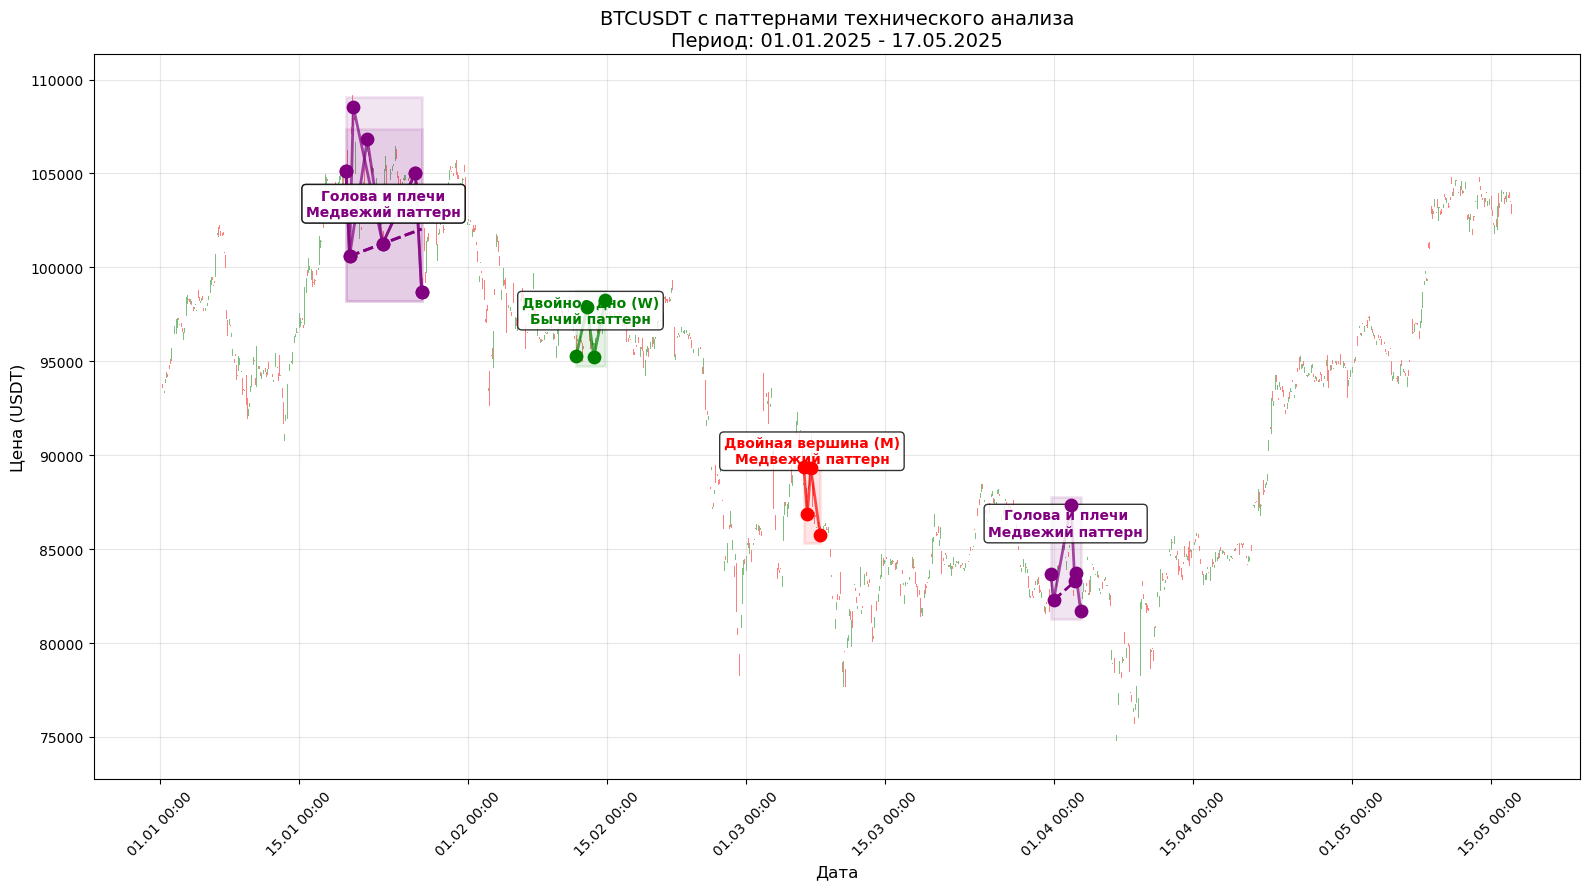

Анализ завершен. График сохранен в файл 'btcusdt_patterns.png'.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from datetime import datetime, timedelta
import matplotlib.dates as mdates
from scipy import signal
import matplotlib.patches as patches

# Функция для получения данных BTCUSDT с Binance API
def get_binance_data(symbol, interval, start_date, end_date):
    base_url = "https://api.binance.com/api/v3/klines"
    
    # Преобразование дат в миллисекунды (timestamp)
    start_ms = int(datetime.strptime(start_date, "%d.%m.%Y").timestamp() * 1000)
    end_ms = int(datetime.strptime(end_date, "%d.%m.%Y").timestamp() * 1000)
    
    # Параметры запроса
    params = {
        "symbol": symbol,
        "interval": interval,
        "startTime": start_ms,
        "endTime": end_ms,
        "limit": 1000
    }
    
    # Может потребоваться несколько запросов для получения всех данных
    all_klines = []
    current_start = start_ms
    
    while current_start < end_ms:
        params["startTime"] = current_start
        response = requests.get(base_url, params=params)
        klines = response.json()
        
        if not klines:
            break
        
        all_klines.extend(klines)
        # Обновляем начальную точку для следующего запроса
        current_start = int(klines[-1][0]) + 1
    
    # Создание DataFrame
    df = pd.DataFrame(all_klines, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume', 
                                         'close_time', 'quote_asset_volume', 'number_of_trades',
                                         'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'])
    
    # Преобразование типов данных
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df['open'] = df['open'].astype(float)
    df['high'] = df['high'].astype(float)
    df['low'] = df['low'].astype(float)
    df['close'] = df['close'].astype(float)
    df['volume'] = df['volume'].astype(float)
    
    return df

# Функция для сглаживания цены (помогает лучше выявлять паттерны)
def smooth_price(price_series, window=8):
    return price_series.rolling(window=window, center=True).mean().fillna(price_series)

# Функция для нахождения локальных максимумов и минимумов
def find_extrema(df, price_col='close', window=10, prominence=0.5):
    """
    Находит локальные экстремумы в ценовой серии.
    
    Параметры:
    df: DataFrame с данными
    price_col: колонка с ценовыми данными
    window: размер окна для поиска экстремумов
    prominence: минимальная выраженность пика/впадины (в % от диапазона цен)
    
    Возвращает: кортеж (индексы пиков, индексы впадин)
    """
    prices = df[price_col].values
    price_range = np.max(prices) - np.min(prices)
    min_prominence = price_range * prominence / 100
    
    # Находим локальные максимумы
    peaks, _ = signal.find_peaks(prices, distance=window, prominence=min_prominence)
    
    # Находим локальные минимумы (инвертируем ряд)
    inverted = -prices
    troughs, _ = signal.find_peaks(inverted, distance=window, prominence=min_prominence)
    
    return peaks, troughs

# 1. Функция для нахождения паттерна двойное дно (W)
def find_double_bottom(df, troughs, peaks, max_width=100, max_height_diff_pct=5.0, v_depth_pct=2.0):
    """
    Находит паттерны двойного дна (W).
    
    Параметры:
    df: DataFrame с данными
    troughs: индексы локальных минимумов
    peaks: индексы локальных максимумов
    max_width: максимальное расстояние между двумя днами
    max_height_diff_pct: максимальная разница в высоте между двумя днами (в процентах)
    v_depth_pct: минимальная глубина V-образного провала между двумя днами (в процентах)
    
    Возвращает: список паттернов двойного дна
    """
    patterns = []
    
    for i in range(len(troughs) - 1):
        trough1_idx = troughs[i]
        trough1_val = df['low'].iloc[trough1_idx]
        
        for j in range(i + 1, len(troughs)):
            trough2_idx = troughs[j]
            trough2_val = df['low'].iloc[trough2_idx]
            
            # Проверка ширины паттерна
            width = trough2_idx - trough1_idx
            if width > max_width:
                break  # Слишком широкий паттерн
            
            # Проверка разницы в высоте между днами
            height_diff_pct = abs(trough2_val - trough1_val) / trough1_val * 100
            if height_diff_pct > max_height_diff_pct:
                continue  # Дна должны быть примерно на одном уровне
            
            # Ищем пик между двумя днами
            middle_peaks = [p for p in peaks if trough1_idx < p < trough2_idx]
            if not middle_peaks:
                continue  # Нет пика между днами
            
            # Берем самый высокий пик между двумя днами
            middle_peak_idx = middle_peaks[np.argmax([df['high'].iloc[p] for p in middle_peaks])]
            middle_peak_val = df['high'].iloc[middle_peak_idx]
            
            # Проверка глубины V-образного провала
            avg_trough = (trough1_val + trough2_val) / 2
            v_depth = (middle_peak_val - avg_trough) / avg_trough * 100
            if v_depth < v_depth_pct:
                continue  # Недостаточная глубина V-образного провала
            
            # Ищем подтверждающий прорыв (пик справа от второго дна)
            confirm_peaks = [p for p in peaks if p > trough2_idx]
            if not confirm_peaks:
                continue  # Нет подтверждающего прорыва
            
            confirm_peak_idx = confirm_peaks[0]
            confirm_peak_val = df['high'].iloc[confirm_peak_idx]
            
            # Подтверждающий пик должен быть выше среднего пика
            if confirm_peak_val < middle_peak_val:
                continue
            
            # Добавляем найденный паттерн
            patterns.append({
                'type': 'Двойное дно (W)',
                'start_idx': trough1_idx,
                'end_idx': confirm_peak_idx,
                'points': [
                    (trough1_idx, trough1_val),
                    (middle_peak_idx, middle_peak_val),
                    (trough2_idx, trough2_val),
                    (confirm_peak_idx, confirm_peak_val)
                ],
                'reliability': v_depth / max(height_diff_pct, 0.1)  # Надежность паттерна
            })
    
    return patterns

# 2. Функция для нахождения паттерна двойная вершина (M)
def find_double_top(df, peaks, troughs, max_width=100, max_height_diff_pct=5.0, m_height_pct=2.0):
    """
    Находит паттерны двойной вершины (M).
    
    Параметры:
    df: DataFrame с данными
    peaks: индексы локальных максимумов
    troughs: индексы локальных минимумов
    max_width: максимальное расстояние между двумя вершинами
    max_height_diff_pct: максимальная разница в высоте между двумя вершинами (в процентах)
    m_height_pct: минимальная высота M-образного возвышения между двумя вершинами (в процентах)
    
    Возвращает: список паттернов двойной вершины
    """
    patterns = []
    
    for i in range(len(peaks) - 1):
        peak1_idx = peaks[i]
        peak1_val = df['high'].iloc[peak1_idx]
        
        for j in range(i + 1, len(peaks)):
            peak2_idx = peaks[j]
            peak2_val = df['high'].iloc[peak2_idx]
            
            # Проверка ширины паттерна
            width = peak2_idx - peak1_idx
            if width > max_width:
                break  # Слишком широкий паттерн
            
            # Проверка разницы в высоте между вершинами
            height_diff_pct = abs(peak2_val - peak1_val) / peak1_val * 100
            if height_diff_pct > max_height_diff_pct:
                continue  # Вершины должны быть примерно на одном уровне
            
            # Ищем впадину между двумя вершинами
            middle_troughs = [t for t in troughs if peak1_idx < t < peak2_idx]
            if not middle_troughs:
                continue  # Нет впадины между вершинами
            
            # Берем самую низкую впадину между двумя вершинами
            middle_trough_idx = middle_troughs[np.argmin([df['low'].iloc[t] for t in middle_troughs])]
            middle_trough_val = df['low'].iloc[middle_trough_idx]
            
            # Проверка высоты M-образного возвышения
            avg_peak = (peak1_val + peak2_val) / 2
            m_height = (avg_peak - middle_trough_val) / avg_peak * 100
            if m_height < m_height_pct:
                continue  # Недостаточная высота M-образного возвышения
            
            # Ищем подтверждающий пробой (впадина справа от второй вершины)
            confirm_troughs = [t for t in troughs if t > peak2_idx]
            if not confirm_troughs:
                continue  # Нет подтверждающего пробоя
            
            confirm_trough_idx = confirm_troughs[0]
            confirm_trough_val = df['low'].iloc[confirm_trough_idx]
            
            # Подтверждающая впадина должна быть ниже средней впадины
            if confirm_trough_val > middle_trough_val:
                continue
            
            # Добавляем найденный паттерн
            patterns.append({
                'type': 'Двойная вершина (M)',
                'start_idx': peak1_idx,
                'end_idx': confirm_trough_idx,
                'points': [
                    (peak1_idx, peak1_val),
                    (middle_trough_idx, middle_trough_val),
                    (peak2_idx, peak2_val),
                    (confirm_trough_idx, confirm_trough_val)
                ],
                'reliability': m_height / max(height_diff_pct, 0.1)  # Надежность паттерна
            })
    
    return patterns

# 3. Функция для нахождения паттерна голова и плечи
def find_head_and_shoulders(df, peaks, troughs, max_width=200, shoulder_diff_pct=15.0, min_height_pct=2.0):
    """
    Находит паттерны голова и плечи.
    
    Параметры:
    df: DataFrame с данными
    peaks: индексы локальных максимумов
    troughs: индексы локальных минимумов
    max_width: максимальное расстояние между левым и правым плечом
    shoulder_diff_pct: максимальная разница в высоте между плечами (в процентах)
    min_height_pct: минимальная высота головы над линией шеи (в процентах)
    
    Возвращает: список паттернов голова и плечи
    """
    patterns = []
    
    for i in range(len(peaks) - 2):
        left_shoulder_idx = peaks[i]
        left_shoulder_val = df['high'].iloc[left_shoulder_idx]
        
        for j in range(i + 1, len(peaks) - 1):
            head_idx = peaks[j]
            head_val = df['high'].iloc[head_idx]
            
            # Голова должна быть выше левого плеча
            if head_val <= left_shoulder_val:
                continue
            
            for k in range(j + 1, len(peaks)):
                right_shoulder_idx = peaks[k]
                right_shoulder_val = df['high'].iloc[right_shoulder_idx]
                
                # Проверка ширины паттерна
                width = right_shoulder_idx - left_shoulder_idx
                if width > max_width:
                    break  # Слишком широкий паттерн
                
                # Плечи должны быть примерно на одном уровне
                shoulder_diff_pct_val = abs(right_shoulder_val - left_shoulder_val) / left_shoulder_val * 100
                if shoulder_diff_pct_val > shoulder_diff_pct:
                    continue
                
                # Голова должна быть выше правого плеча
                if head_val <= right_shoulder_val:
                    continue
                
                # Ищем впадины между левым плечом и головой, и между головой и правым плечом
                left_trough_candidates = [t for t in troughs if left_shoulder_idx < t < head_idx]
                right_trough_candidates = [t for t in troughs if head_idx < t < right_shoulder_idx]
                
                if not left_trough_candidates or not right_trough_candidates:
                    continue  # Нет впадин для формирования линии шеи
                
                # Берем самые низкие впадины
                left_trough_idx = left_trough_candidates[np.argmin([df['low'].iloc[t] for t in left_trough_candidates])]
                right_trough_idx = right_trough_candidates[np.argmin([df['low'].iloc[t] for t in right_trough_candidates])]
                
                left_trough_val = df['low'].iloc[left_trough_idx]
                right_trough_val = df['low'].iloc[right_trough_idx]
                
                # Вычисляем линию шеи
                neckline_left = (left_trough_idx, left_trough_val)
                neckline_right = (right_trough_idx, right_trough_val)
                
                # Находим высоту головы над линией шеи
                # Для простоты считаем линию шеи горизонтальной на уровне более высокой впадины
                neckline_val = max(left_trough_val, right_trough_val)
                head_height_pct = (head_val - neckline_val) / neckline_val * 100
                
                if head_height_pct < min_height_pct:
                    continue  # Голова недостаточно высока над линией шеи
                
                # Ищем подтверждение (пробой линии шеи после правого плеча)
                confirm_troughs = [t for t in troughs if t > right_shoulder_idx]
                if not confirm_troughs:
                    continue
                
                confirm_trough_idx = confirm_troughs[0]
                confirm_trough_val = df['low'].iloc[confirm_trough_idx]
                
                # Линейная интерполяция для определения значения линии шеи в точке подтверждения
                if right_trough_idx == left_trough_idx:  # Избегаем деления на ноль
                    neckline_at_confirm = neckline_val
                else:
                    slope = (right_trough_val - left_trough_val) / (right_trough_idx - left_trough_idx)
                    intercept = left_trough_val - slope * left_trough_idx
                    neckline_at_confirm = slope * confirm_trough_idx + intercept
                
                # Проверяем, что цена пробила линию шеи
                if confirm_trough_val > neckline_at_confirm:
                    continue
                
                # Добавляем найденный паттерн
                patterns.append({
                    'type': 'Голова и плечи',
                    'start_idx': left_shoulder_idx,
                    'end_idx': confirm_trough_idx,
                    'points': [
                        (left_shoulder_idx, left_shoulder_val),
                        (left_trough_idx, left_trough_val),
                        (head_idx, head_val),
                        (right_trough_idx, right_trough_val),
                        (right_shoulder_idx, right_shoulder_val),
                        (confirm_trough_idx, confirm_trough_val)
                    ],
                    'neckline': [(left_trough_idx, left_trough_val), (right_trough_idx, right_trough_val)],
                    'reliability': head_height_pct / max(shoulder_diff_pct_val, 0.1)  # Надежность паттерна
                })
    
    return patterns

# Функция для построения графика с паттернами
def plot_chart_with_patterns(df, patterns):
    """
    Строит график с обозначенными паттернами.
    
    Параметры:
    df: DataFrame с данными
    patterns: список паттернов
    """
    fig, ax = plt.figure(figsize=(16, 9)), plt.subplot(111)
    
    # Построение свечного графика
    width = 0.8 * (df['timestamp'].iloc[1] - df['timestamp'].iloc[0]).total_seconds() / 86400
    up = df[df['close'] >= df['open']]
    down = df[df['close'] < df['open']]
    
    # Зеленые свечи (цена растет)
    ax.bar(up['timestamp'], up['close'] - up['open'], width, bottom=up['open'], color='green', alpha=0.5)
    ax.bar(up['timestamp'], up['high'] - up['close'], width*0.1, bottom=up['close'], color='green', alpha=0.5)
    ax.bar(up['timestamp'], up['low'] - up['open'], width*0.1, bottom=up['open'], color='green', alpha=0.5)
    
    # Красные свечи (цена падает)
    ax.bar(down['timestamp'], down['close'] - down['open'], width, bottom=down['open'], color='red', alpha=0.5)
    ax.bar(down['timestamp'], down['high'] - down['open'], width*0.1, bottom=down['open'], color='red', alpha=0.5)
    ax.bar(down['timestamp'], down['low'] - down['close'], width*0.1, bottom=down['close'], color='red', alpha=0.5)
    
    # Словарь цветов для паттернов
    pattern_colors = {
        'Двойное дно (W)': 'green',
        'Двойная вершина (M)': 'red',
        'Голова и плечи': 'purple'
    }
    
    # Отображение паттернов
    for pattern in patterns:
        pattern_type = pattern['type']
        color = pattern_colors.get(pattern_type, 'blue')
        
        # Получаем точки паттерна
        points = pattern['points']
        timestamps = [df['timestamp'].iloc[idx] for idx, _ in points]
        values = [val for _, val in points]
        
        # Отображаем линии паттерна
        if pattern_type == 'Голова и плечи':
            # Отображаем дополнительно линию шеи
            neckline = pattern['neckline']
            neckline_indices = [idx for idx, _ in neckline]
            neckline_values = [val for _, val in neckline]
            
            # Продлеваем линию шеи до конца паттерна
            if neckline_indices[1] == neckline_indices[0]:  # Избегаем деление на ноль
                slope = 0
                intercept = neckline_values[0]
            else:
                slope = (neckline_values[1] - neckline_values[0]) / (neckline_indices[1] - neckline_indices[0])
                intercept = neckline_values[0] - slope * neckline_indices[0]
            
            end_idx = pattern['end_idx']
            neckline_extension = [(idx, slope * idx + intercept) for idx in range(neckline_indices[1], end_idx + 1)]
            
            # Отображаем линию шеи
            neckline_timestamps = [df['timestamp'].iloc[idx] for idx, _ in neckline + neckline_extension]
            neckline_values = [val for _, val in neckline + neckline_extension]
            
            ax.plot(neckline_timestamps, neckline_values, color=color, linestyle='--', linewidth=2)
        
        # Отображаем линии паттерна
        ax.plot(timestamps, values, color=color, alpha=0.7, linewidth=2)
        
        # Отображаем точки паттерна
        ax.scatter(timestamps, values, color=color, s=80, zorder=5)
        
        # Добавляем текст с информацией о паттерне
        mid_idx = (pattern['start_idx'] + pattern['end_idx']) // 2
        if 0 <= mid_idx < len(df):
            mid_price = df['close'].iloc[mid_idx]
            text_y_offset = (df['high'].max() - df['low'].min()) * 0.05
            
            # Определяем направление паттерна (бычий/медвежий)
            if pattern_type == 'Двойное дно (W)':
                sentiment = "Бычий"
            elif pattern_type in ['Двойная вершина (M)', 'Голова и плечи']:
                sentiment = "Медвежий"
            else:
                sentiment = ""
            
            ax.text(df['timestamp'].iloc[mid_idx], mid_price + text_y_offset, 
                    f"{pattern_type}\n{sentiment} паттерн", 
                    bbox=dict(facecolor='white', alpha=0.8, boxstyle='round'),
                    ha='center', va='center', color=color, fontweight='bold')
            
            # Добавляем прямоугольник для выделения области паттерна
            start_date = df['timestamp'].iloc[pattern['start_idx']]
            end_date = df['timestamp'].iloc[pattern['end_idx']]
            min_val = min([val for _, val in points]) * 0.995
            max_val = max([val for _, val in points]) * 1.005
            
            rect = patches.Rectangle(
                (start_date, min_val), 
                end_date - start_date, 
                max_val - min_val, 
                linewidth=2, 
                edgecolor=color, 
                facecolor=color, 
                alpha=0.1
            )
            ax.add_patch(rect)
    
    # Настройка графика
    plt.title(f'BTCUSDT с паттернами технического анализа\n'
              f'Период: {df["timestamp"].iloc[0].strftime("%d.%m.%Y")} - {df["timestamp"].iloc[-1].strftime("%d.%m.%Y")}',
              fontsize=14)
    plt.xlabel('Дата', fontsize=12)
    plt.ylabel('Цена (USDT)', fontsize=12)
    plt.grid(alpha=0.3)
    
    # Форматирование оси X для лучшего отображения дат
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m %H:%M'))
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.savefig('btcusdt_patterns.png', dpi=300)
    plt.show()

# Основной код
def main():
    # Параметры
    symbol = "BTCUSDT"
    interval = "1h"
    start_date = "01.01.2025"
    end_date = "17.05.2025"
    
    # Получение данных
    print(f"Загрузка данных {symbol} с {start_date} по {end_date}...")
    df = get_binance_data(symbol, interval, start_date, end_date)
    print(f"Загружено {len(df)} свечей.")
    
    # Сглаживание цены для лучшего обнаружения пиков
    df['smooth'] = smooth_price(df['close'], window=8)
    
    # Нахождение локальных экстремумов
    print("Поиск локальных экстремумов...")
    peaks, troughs = find_extrema(df, price_col='smooth', window=12, prominence=0.3)
    
    # Поиск паттернов
    print("Поиск паттерна двойное дно (W)...")
    double_bottoms = find_double_bottom(df, troughs, peaks, max_width=100, max_height_diff_pct=5.0, v_depth_pct=2.0)
    
    print("Поиск паттерна двойная вершина (M)...")
    double_tops = find_double_top(df, peaks, troughs, max_width=100, max_height_diff_pct=5.0, m_height_pct=2.0)
    
    print("Поиск паттерна голова и плечи...")
    head_and_shoulders = find_head_and_shoulders(df, peaks, troughs, max_width=200, shoulder_diff_pct=15.0, min_height_pct=2.0)
    
    # Объединяем все паттерны
    all_patterns = double_bottoms + double_tops + head_and_shoulders
    
    # Сортируем по надежности
    all_patterns.sort(key=lambda x: x.get('reliability', 0), reverse=True)
    
    # Берем только лучшие паттерны каждого типа (для уменьшения перегруженности графика)
    best_patterns = []
    pattern_types_added = set()
    
    for pattern in all_patterns:
        if len(best_patterns) >= 10:  # Ограничиваем количество паттернов на графике
            break
        
        if pattern['type'] not in pattern_types_added or len(best_patterns) < 3:
            best_patterns.append(pattern)
            pattern_types_added.add(pattern['type'])
    
    # Вывод информации о найденных паттернах
    print(f"\nВсего найдено паттернов: {len(all_patterns)}")
    print(f"Двойное дно (W): {len(double_bottoms)}")
    print(f"Двойная вершина (M): {len(double_tops)}")
    print(f"Голова и плечи: {len(head_and_shoulders)}")
    
    print("\nЛучшие паттерны для отображения на графике:")
    for i, pattern in enumerate(best_patterns):
        start_date = df['timestamp'].iloc[pattern['start_idx']].strftime('%d.%m.%Y %H:%M')
        end_date = df['timestamp'].iloc[pattern['end_idx']].strftime('%d.%m.%Y %H:%M')
        print(f"{i+1}. {pattern['type']}: с {start_date} по {end_date}, надежность: {pattern['reliability']:.2f}")
    
    # Построение графика
    print("\nПостроение графика с паттернами...")
    plot_chart_with_patterns(df, best_patterns)
    
    print("Анализ завершен. График сохранен в файл 'btcusdt_patterns.png'.")

if __name__ == "__main__":
    main()

Код для определения паттернов "Голова и плечи", "Двойная вершина" и "Двойное дно" использует алгоритмический подход на основе анализа локальных экстремумов (пиков и впадин) на графике. Давайте разберем логику для каждого паттерна:

### 1. Паттерн "Голова и плечи"
Функция find_head_and_shoulders() выстраивает этот паттерн следующим образом:

Структура поиска: Код ищет последовательность из трех пиков (левое плечо, голова, правое плечо) и двух впадин между ними, формирующих "линию шеи".
Ключевые проверки:

* Голова должна быть выше обоих плеч
* Плечи должны быть примерно на одном уровне (разница не превышает shoulder_diff_pct = 15%)
* Между пиками должны находиться впадины для формирования линии шеи
* Высота головы над линией шеи должна быть значительной (не менее min_height_pct = 2%)
* После правого плеча должен быть пробой линии шеи вниз для подтверждения паттерна

Расчет линии шеи: Линия проводится через две впадины, находящиеся между левым плечом и головой, и между головой и правым плечом.
Подтверждение: Код ищет впадину после правого плеча, которая должна быть ниже линии шеи (пробой), что свидетельствует о завершении формирования паттерна.
Надежность: Рассчитывается как отношение высоты головы над линией шеи к разнице в высоте плеч.

### 2. Паттерн "Двойная вершина (М)"
Функция find_double_top() определяет этот паттерн так:

Структура поиска: Код ищет два последовательных пика примерно одинаковой высоты и впадину между ними.
Ключевые проверки:

* Вершины должны быть примерно на одном уровне (разница не более max_height_diff_pct = 5%)
* Между вершинами должна быть значительная впадина (m_height_pct = 2%)
* Паттерн не должен быть слишком широким (не более max_width = 100 свечей)
* После второй вершины должен быть пробой вниз (подтверждающая впадина ниже средней впадины)

Подтверждение: Код ищет впадину после второй вершины, которая должна быть ниже впадины между вершинами.
Надежность: Рассчитывается как отношение глубины впадины между вершинами к разнице в высоте вершин.

### 3. Паттерн "Двойное дно (W)"
Функция find_double_bottom() строит этот паттерн следующим образом:

Структура поиска: Код ищет две последовательные впадины примерно одинаковой глубины и пик между ними.
Ключевые проверки:

* Дна должны быть примерно на одном уровне (разница не более max_height_diff_pct = 5%)
* Между днами должен быть значительный пик (v_depth_pct = 2%)
* Паттерн не должен быть слишком широким (не более max_width = 100 свечей)
* После второго дна должен быть пробой вверх (подтверждающий пик выше среднего пика)


Подтверждение: Код ищет пик после второго дна, который должен быть выше пика между днами.
Надежность: Рассчитывается как отношение высоты пика между днами к разнице в глубине дна.

### Общий процесс обнаружения паттернов

* Загрузка и предварительная обработка данных (сглаживание цены для уменьшения шума)
* Нахождение локальных экстремумов (пиков и впадин) с помощью функции find_extrema()
* Поиск каждого типа паттерна отдельно с помощью соответствующих функций
* Сортировка всех найденных паттернов по надежности
* Выбор наиболее надежных паттернов для отображения на графике (не более 10 и не больше 3 одного типа)
* Визуализация отобранных паттернов на графике

### Для визуализации код:

* Рисует линии между ключевыми точками паттерна
* Для "Головы и плеч" дополнительно рисует линию шеи
* Выделяет область паттерна прямоугольником с полупрозрачной заливкой
* Добавляет подписи с типом паттерна и его характером (бычий/медвежий)
* Использует цветовую кодировку: зеленый для бычьих паттернов (Двойное дно), красный для медвежьих (Двойная вершина), фиолетовый для "Головы и плеч"

Код также рассчитывает "надежность" каждого паттерна на основе его геометрических характеристик, что позволяет отбирать наиболее качественные примеры для отображения.